In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [3]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS= 50

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/training/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [6]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[1 1 2 0 0 0 0 1 2 1 0 1 1 0 2 1 1 1 1 1 1 1 0 1 2 0 1 1 0 1 1 0]


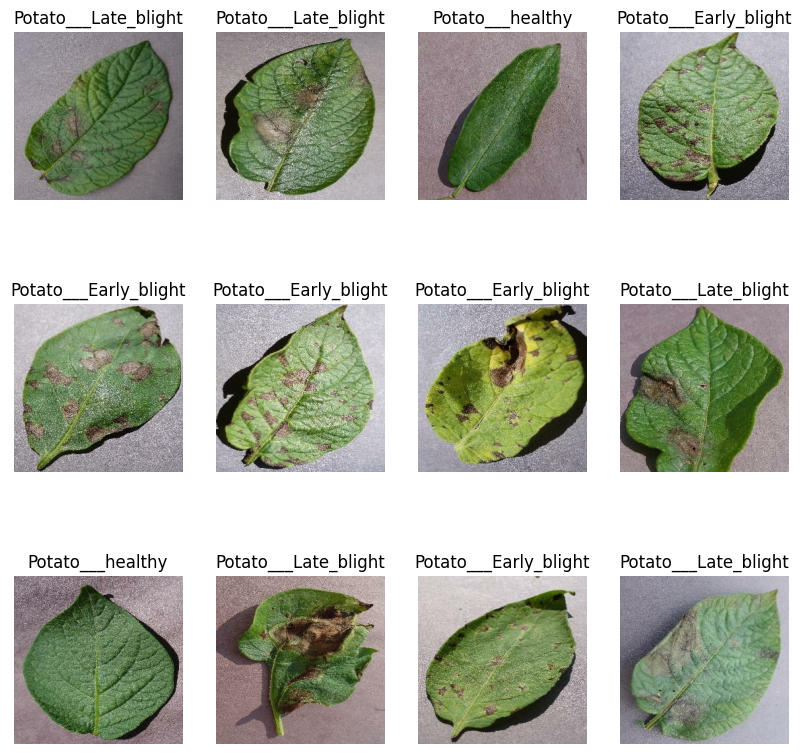

In [7]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.numpy())
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

 80% = Training
 20% = Test
    10% = validate
    10% = Test


In [8]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds=dataset.take(54)
len(train_ds)

54

In [10]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [11]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [16]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
## normalize
for image_batch, labels_batch in dataset.take(1):
  print(image_batch[0].numpy()/255)

[[[0.59607846 0.5803922  0.63529414]
  [0.6039216  0.5882353  0.6431373 ]
  [0.6117647  0.59607846 0.6509804 ]
  ...
  [0.59607846 0.5803922  0.63529414]
  [0.5686275  0.5529412  0.60784316]
  [0.54509807 0.5294118  0.58431375]]

 [[0.6156863  0.6        0.654902  ]
  [0.6117647  0.59607846 0.6509804 ]
  [0.6117647  0.59607846 0.6509804 ]
  ...
  [0.5882353  0.57254905 0.627451  ]
  [0.6039216  0.5882353  0.6431373 ]
  [0.60784316 0.5921569  0.64705884]]

 [[0.6117647  0.59607846 0.6509804 ]
  [0.6        0.58431375 0.6392157 ]
  [0.59607846 0.5803922  0.63529414]
  ...
  [0.5686275  0.5529412  0.60784316]
  [0.5882353  0.57254905 0.627451  ]
  [0.58431375 0.5686275  0.62352943]]

 ...

 [[0.7764706  0.78431374 0.83137256]
  [0.77254903 0.78039217 0.827451  ]
  [0.77254903 0.78039217 0.827451  ]
  ...
  [0.7764706  0.7882353  0.8235294 ]
  [0.7764706  0.7882353  0.8235294 ]
  [0.7764706  0.7882353  0.8235294 ]]

 [[0.7647059  0.77254903 0.81960785]
  [0.7647059  0.77254903 0.81960785]


In [18]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1.0/255)
])

# Data Agumentation

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2)
])

In [20]:
model=models.Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(len(class_names), activation='softmax'),
])
model.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30
)


Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 652s 155ms/step - accuracy: 0.4848 - loss: 0.9346 - val_accuracy: 0.7135 - val_loss: 0.7774
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.6985 - loss: 0.7246 - val_accuracy: 0.7969 - val_loss: 0.4911
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8040 - loss: 0.4660 - val_accuracy: 0.9167 - val_loss: 0.2809
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8374 - loss: 0.3551 - val_accuracy: 0.7448 - val_loss: 0.6519
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8680 - loss: 0.3260 - val_accuracy: 0.8958 - val_loss: 0.2441
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9319 - loss: 0.1893 - val_accuracy: 0.8958 - val_loss: 0.2428
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9597 - loss: 0.1080 - val_accuracy: 0.7240 - val_loss: 0.8818
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9306 - loss: 0.1670 - val_accuracy: 0.9219 

In [24]:
scores=model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.9665 - loss: 0.0689


In [25]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [26]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

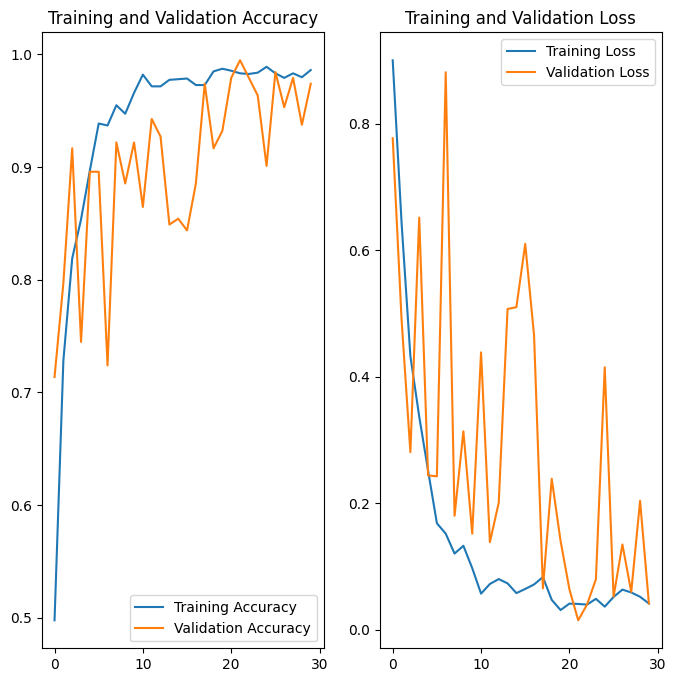

In [27]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predit
Actual Label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Predicted Label: Potato___Late_blight


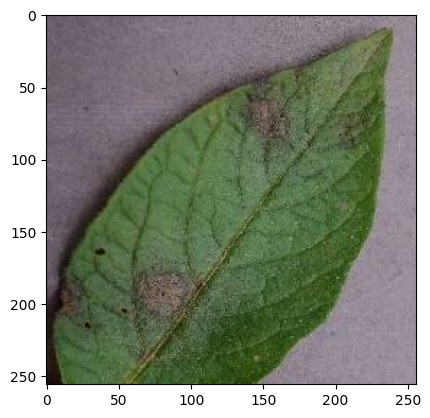

In [28]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
  first_image=images_batch[0].numpy().astype('uint8')

  print("First image to predit")
  plt.imshow(first_image)
  print("Actual Label:",class_names[labels_batch[0].numpy()])

  batch_prediction=model.predict(image_batch)
  print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])


In [29]:
def predict(model, img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array, 0)

  predictions=model.predict(img_array)

  predicted_class=class_names[np.argmax(predictions[0])]
  confidence=round(100*(np.max(predictions[0])),2)
  return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


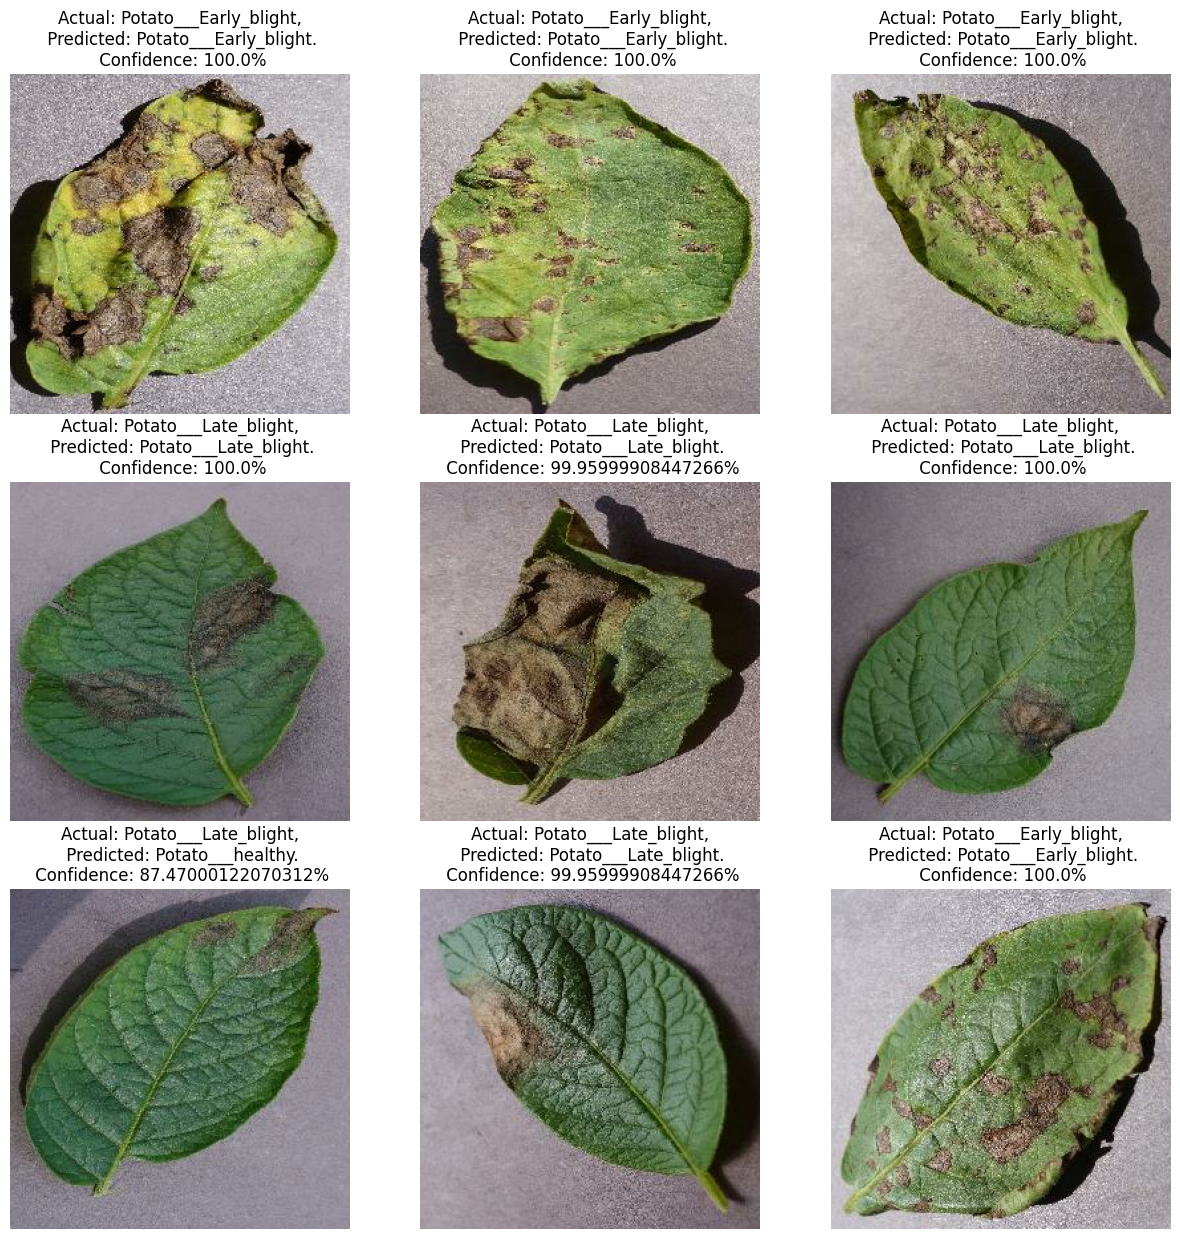

In [30]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence=predict(model, images[i].numpy())
    actual_class=class_names[labels[i]]
    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
    plt.axis("off")

In [34]:
model.save('/content/drive/MyDrive/saved_model.keras')

Now that the model is saved, you can evaluate its performance on the test dataset and visualize the training history.

In [ ]:
scores = model.evaluate(test_ds)
print("Test Loss:", scores[0])
print("Test Accuracy:", scores[1])

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()